# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.605400,False,-2.430845
1,-1.368961,False,-3.193706
2,-2.114426,False,-3.610335
3,-2.350118,False,-3.255377
4,-0.568342,True,3.446698
...,...,...,...
995,-1.903767,False,-2.318071
996,-0.250272,True,3.566106
997,-0.700577,False,-0.732529
998,-0.930455,False,-2.702110


<Axes: xlabel='v0'>

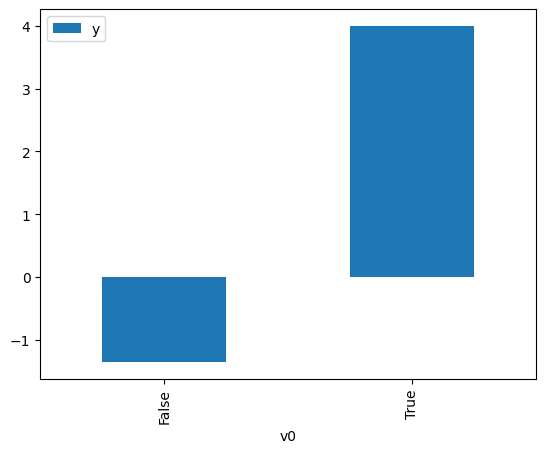

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

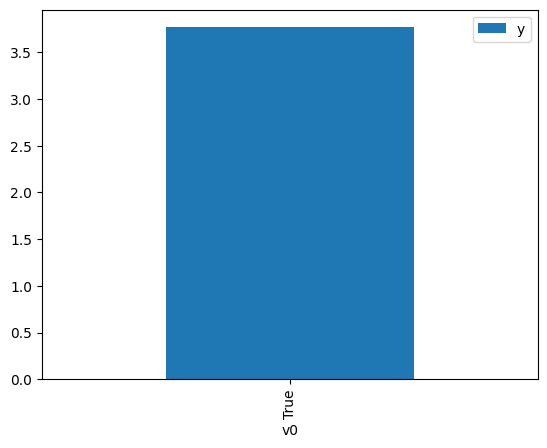

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.184308,False,-2.103618,0.814457,1.227812
1,-1.630266,False,-0.220573,0.882268,1.133442
2,-1.217366,False,-1.807973,0.820374,1.218956
3,-0.783857,False,-0.720287,0.730854,1.368263
4,0.042496,False,2.082588,0.501970,1.992151
...,...,...,...,...,...
995,-0.477462,False,-0.612594,0.652826,1.531801
996,-0.295923,False,0.264973,0.601989,1.661160
997,-0.072101,False,-0.384313,0.536267,1.864744
998,0.086631,False,0.049033,0.488739,2.046083


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.658133,True,2.417753,0.299816,3.335375
1,-1.213479,True,3.112584,0.180314,5.545876
2,-1.213479,True,3.112584,0.180314,5.545876
3,-1.644416,True,2.730602,0.115980,8.622163
4,-0.799718,True,5.219624,0.265421,3.767602
...,...,...,...,...,...
995,-1.883239,True,3.044389,0.089685,11.150165
996,-1.522229,True,4.677731,0.131871,7.583167
997,-0.187132,True,3.947760,0.429649,2.327480
998,-0.233584,True,4.339317,0.416054,2.403535


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.911
Model:                            OLS   Adj. R-squared (uncentered):              0.911
Method:                 Least Squares   F-statistic:                              5100.
Date:                Wed, 15 Nov 2023   Prob (F-statistic):                        0.00
Time:                        16:17:36   Log-Likelihood:                         -1404.7
No. Observations:                1000   AIC:                                      2813.
Df Residuals:                     998   BIC:                                      2823.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.4183      0.023     61.699      0.000       1.373       1.463
x2             4.9807      0.058     85.157      0.000       4.866       5.096
==============================================================================
Omnibus:                        3.414   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.181   Jarque-Bera (JB):                3.486
Skew:                           0.135   Prob(JB):                        0.175
Kurtosis:                       2.895   Cond. No.                         2.56
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""